In [1]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler 
from sklearn.linear_model import LogisticRegression  
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, f1_score
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.tree import DecisionTreeClassifier
from matplotlib import pyplot as plt
import pickle 
from xgboost import XGBClassifier

import mlflow
from mlflow.tracking import MlflowClient 

import datetime as dt

import warnings
warnings.filterwarnings("ignore")

In [2]:
RANDOM_STATE = 42

## Load data from pickle

In [3]:
clients = pd.read_pickle('clients_labeled_cleaned_08_03_2023.pkl')

In [4]:
clients.head()

,age,sexe,taux,situationFamiliale,nbEnfantsAcharge,VoitureN2,label,tranche_age
0,62.0,Masculin,1262.0,En Couple,1.0,Non,2,2
1,68.0,Masculin,514.0,En Couple,2.0,Non,2,2
2,26.0,Féminin,181.0,En Couple,4.0,Oui,1,0
3,34.0,Masculin,829.0,Célibataire,0.0,Non,3,0
4,50.0,Masculin,1169.0,En Couple,4.0,Non,4,1


## Transformations

In [5]:
y = clients['label']
X = clients.drop(columns=["label"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=RANDOM_STATE, stratify=y)

In [6]:
column_transformer = ColumnTransformer( 
    [
        ('ohe', OneHotEncoder(drop="if_binary"), ["sexe", 'situationFamiliale', 'VoitureN2', 'tranche_age']),
        ('scaling', MinMaxScaler(), ['taux', 'nbEnfantsAcharge', 'age']),
    ]
)
pipeline_clients = Pipeline(steps = [
    ('scaling', column_transformer)
])

X_train = pipeline_clients.fit_transform(X_train)
X_test = pipeline_clients.transform(X_test)

In [7]:
## Save the data_preprocessor object
with open("data_transformer.pkl", 'wb') as file:
    pickle.dump(pipeline_clients, file)

## Fit & Log

In [8]:
class Trainer :
    def __init__(self, X_train, X_test, y_train, y_test, models, params_grid, scorings, experiment_id=1) :
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.models = models
        self.params_grid = params_grid
        self.scorings = scorings
        self.models_cv = {}
        self.experiment_id = experiment_id  
        
    def run(self, verbose=True):
        accs = precs = f1s = {}
        try :
            # Load experiment or create new 
            experiment_name = 'experiment_'+str(self.experiment_id) + '_grid_search'
            experiment_id = mlflow.get_experiment_by_name(experiment_name)
            experiment_id = experiment_id.experiment_id if experiment_id else mlflow.create_experiment(experiment_name)

            for model, param_grid, scoring in zip(self.models, self.params_grid, self.scorings) :
                # set a concatenation model and datetime for each run
                with mlflow.start_run(run_name=model+"_"+str(dt.datetime.now())[0:-10], experiment_id=experiment_id) :  
                    # define and train gridsearch for each model with its params
                    model_cv = GridSearchCV(estimator = models_test[model], param_grid=param_grid, scoring=scoring, refit='accuracy', cv=5, n_jobs=-1)
                    model_cv.fit(self.X_train, self.y_train)

                    # add each model to a models list
                    self.models_cv[model] = model_cv 

                    # make predictions
                    pred_train = model_cv.predict(self.X_train)
                    pred_test = model_cv.predict(self.X_test)

                    # compute and logs metrics for each model
                    accs[model], precs[model], f1s[model] = self.compute_metrics(pred_train, pred_test, model, verbose)

                    cm_train = confusion_matrix(self.y_train, pred_train)
                    cm_test = confusion_matrix(self.y_test, pred_test)

                    # log others items
                    mlflow.sklearn.log_model(model_cv, model)
                    mlflow.log_param("model", model)
                    mlflow.log_params(model_cv.best_params_) 
                    mlflow.set_tag('estimator_class', type(model_cv))
        except Exception as e : 
            print("Une erreur est survenue : ", e)
        return accs, precs, f1s
         
                    
    def compute_metrics(self, pred_train, pred_test, model, verbose) :
        acc_train = accuracy_score(self.y_train, pred_train)
        acc_test = accuracy_score(self.y_test, pred_test)
        prec_train = precision_score(self.y_train, pred_train, average='macro')
        prec_test = precision_score(self.y_test, pred_test, average='macro') 
        f1_train = f1_score(self.y_train, pred_train, average='micro')
        f1_test = f1_score(self.y_test, pred_test, average='micro') 
        
        mlflow.log_metric("accuracy_train", acc_train)
        mlflow.log_metric("accuracy_test", acc_test)
        mlflow.log_metric("precision_train", prec_train)
        mlflow.log_metric("precision_test", prec_test)
        mlflow.log_metric("f1_score_train", f1_train)
        mlflow.log_metric("f1_score_test", f1_test)
        
        if(verbose):
            self.display_metrics(model, acc_train, acc_test, prec_train, prec_test, f1_train, f1_test)
            
        return {"train" : acc_train, "test":acc_test}, {"train":prec_train, "test":prec_test}, {"train":f1_train, "test":f1_test}
        
        
    def display_metrics(self, model, acc_train, acc_test, prec_train, prec_test, f1_train, f1_test):
        print(model)
        print('-'*10)
        print(f"accuracy score on train : {acc_train*100:.2f}%")
        print(f"accuracy score on test: {acc_test*100:.2f}%")
        print()
        print(f"precision score on train : {prec_train*100:.2f}%")
        print(f"precision score on test : {prec_test*100:.2f}%")
        print()
        print(f"f1 score on train: {f1_train*100:.2f}%")
        print(f"f1 score on test: {f1_test*100:.2f}%")
        print()

In [9]:
models_test = {
    "log_reg": LogisticRegression(random_state=RANDOM_STATE, n_jobs=-1), 
    "random forest" : RandomForestClassifier(bootstrap=False, n_jobs=-1, random_state=RANDOM_STATE), 
#     "adaboost" : AdaBoostClassifier(random_state=RANDOM_STATE),
    "xgboost" : XGBClassifier(subsample=0.2, random_state=RANDOM_STATE),
    "knn" : KNeighborsClassifier(n_jobs=-1), 
}
params_grid = [
    {'solver' : ["lbfgs", "elasticnet"], "penalty" : ["l2", "l1"], "C":[1, .1, .01] ,"max_iter": [1000]},  
    {'n_estimators': [300], 'max_depth': [None, 5, 10, 15], 'min_samples_split': [2, 5, 10], 'min_samples_leaf':[2, 5, 10], 'criterion' : ['gini'], 'max_features': ['auto', 'sqrt']}, 
#     {'n_estimators': [250], 'learning_rate': [0.1, 0.05], 'base_estimator': [DecisionTreeClassifier(min_samples_split=5, min_samples_leaf=5, max_depth=None, random_state=RANDOM_STATE)] },
    {'max_depth': [3, 5, 7], 'learning_rate': [0.1, 0.01, 0.05], 'n_estimators': [200, 300, 400]},
    {'n_neighbors': [15, 20, 25], 'weights': ['uniform']},
]
scorings = [['accuracy', 'precision']] * len(models_test)


trainer = Trainer(X_train, X_test, y_train, y_test, models_test, params_grid, scorings, experiment_id=1)
accs, precs, f1s = trainer.run()

log_reg
----------
accuracy score on train : 69.83%
accuracy score on test: 70.05%

precision score on train : 67.57%
precision score on test : 67.74%

f1 score on train: 69.83%
f1 score on test: 70.05%

random forest
----------
accuracy score on train : 76.77%
accuracy score on test: 74.61%

precision score on train : 81.61%
precision score on test : 78.95%

f1 score on train: 76.77%
f1 score on test: 74.61%

xgboost
----------
accuracy score on train : 76.29%
accuracy score on test: 74.53%

precision score on train : 80.99%
precision score on test : 78.75%

f1 score on train: 76.29%
f1 score on test: 74.53%

knn
----------
accuracy score on train : 76.66%
accuracy score on test: 73.80%

precision score on train : 80.07%
precision score on test : 76.34%

f1 score on train: 76.66%
f1 score on test: 73.80%



In [10]:
for name, model in trainer.models_cv.items() : 
    print(name, " => ", model.best_params_) 
    print()

log_reg  =>  {'C': 1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}

random forest  =>  {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 300}

xgboost  =>  {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200}

knn  =>  {'n_neighbors': 25, 'weights': 'uniform'}



[]

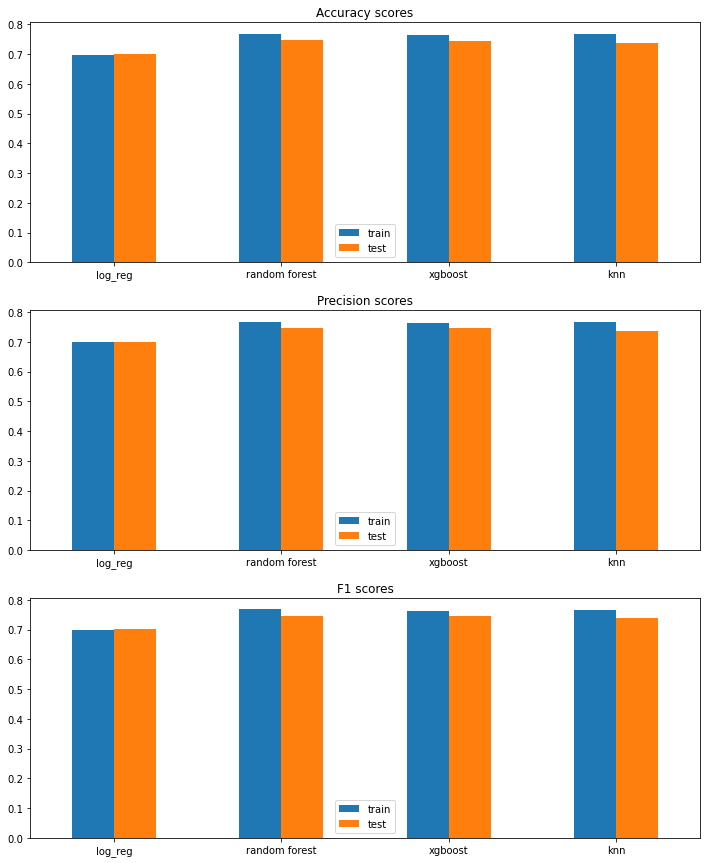

In [11]:
# plot metrics of each model  
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(12,15))

accs = pd.DataFrame.from_dict(accs, orient='index')
accs.plot(kind="bar", rot=0, title="Accuracy scores", ax=axs[0])

precs = pd.DataFrame.from_dict(precs, orient='index')
precs.plot(kind="bar", rot=0, title="Precision scores", ax=axs[1])

f1s = pd.DataFrame.from_dict(f1s, orient='index')
f1s.plot(kind="bar", rot=0, title="F1 scores", ax=axs[2])

plt.plot()

## Confusion matrix

In [14]:
for name, model in trainer.models_cv.items() : 
    print(name, "-"*10, sep="\n") 
    predictions = model.best_estimator_.predict(X_test)
    print(confusion_matrix(y_test, predictions))
    print()
    

log_reg
----------
[[1663    1    3 2908    0]
 [   1 6583 2567    3    3]
 [   0 2245 7465    2  945]
 [1667    1    2 9138    0]
 [   0  226 1184    2 2660]]

random forest
----------
[[ 2342     1     3  2229     0]
 [    0  5439  3711     4     3]
 [    0     9 10634     2    12]
 [ 2341     1     2  8464     0]
 [    1     1  1650     1  2419]]

xgboost
----------
[[ 2176     1     3  2395     0]
 [    1  5441  3709     3     3]
 [    0     5 10648     2     2]
 [ 2219     1     2  8586     0]
 [    1     1  1652     1  2417]]

knn
----------
[[ 2185     1     3  2386     0]
 [    0  5610  3541     4     2]
 [    2   326 10164     5   160]
 [ 2231     1     2  8574     0]
 [    4    36  1585     1  2446]]



<font color=blue size=4>On constate grâce à aux différentes matrices de confusion que les modèles font beaucoup plus d'erreurs sur la classe 0. </font>